In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

from keras.layers import BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers import Dense, Flatten, Input

from keras.models import Model
from keras.layers import concatenate
from keras import backend as k

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
class GoogLeNet:
    @staticmethod
    def _conv_module(inputs, 
                    filters,
                    kernel_size, 
                    stride, 
                    padding,
                    activation="relu"):
        
        x = Conv2D(filters, kernel_size=kernel_size, strides=stride,
                        padding=padding)(inputs)
        
        x = BatchNormalization(axis=-1)(x)
        
        x = Activation(activation)(x)
        return x
    
    
    @staticmethod
    def _incpetion_module(inputs,
                         single_filter,
                         filters1X1_1,
                         filters1X1_2,
                         filters2X2_1,
                         filters2X2_2,
                         max_conv_filter):
        single_conv = Conv2D(single_filter, kernel_size=(1, 1), strides=(1, 1),
                        padding="same", activation="relu")(inputs)
        
        conv_1X1 = GoogLeNet._conv_module(inputs, filters1X1_1, (1, 1), 
                                        (1, 1), "same")
        conv_1X1 = GoogLeNet._conv_module(conv_1X1, filters1X1_2, (3, 3),
                                         (1, 1), "same")
        
        
        conv_3X3 = GoogLeNet._conv_module(inputs, filters2X2_1, (1, 1), 
                                        (1, 1), "same")
        conv_3X3 = GoogLeNet._conv_module(conv_3X3, filters2X2_2, (5, 5),
                                         (1, 1), "same")
        
        max_conv = MaxPooling2D((1, 1), (1, 1))(inputs)
        max_conv = GoogLeNet._conv_module(max_conv, max_conv_filter, (1, 1), (1, 1), "same")
        
        x = concatenate([single_conv, conv_1X1, conv_3X3, max_conv], axis=-1)
        return x
        
    @staticmethod
    def build(width, height, depth, classes, auxiliary_output=False):
        inputShape = [height, width, depth]
        
        inputs = Input(shape=inputShape)
        
        x = GoogLeNet._conv_module(inputs, 64, (7, 7), (2, 2), "same")
        x = MaxPooling2D((3, 3), (2, 2))(x)
        x = keras.layers.Lambda(tf.nn.local_response_normalization)(x)
        
        x = GoogLeNet._conv_module(x, 64, (1, 1), (1, 1), "same")
        x = GoogLeNet._conv_module(x, 192, (3, 3), (1, 1), "same")
        x = keras.layers.Lambda(tf.nn.local_response_normalization)(x)
        x = MaxPooling2D((3, 3), (2, 2))(x)
        
        x = GoogLeNet._incpetion_module(x, 64, 96, 128, 16, 32, 32)
        x = GoogLeNet._incpetion_module(x, 128, 128, 192, 32, 96, 64)
        x = MaxPooling2D((3, 3), (2, 2))(x)
        
        x = GoogLeNet._incpetion_module(x, 192, 96, 208, 16, 48, 64)
        
        # Adding auxiliary Output 1
        if auxiliary_output:
            aux_output1 = AveragePooling2D((5,5), (3, 3))(x)
            aux_output1 = GoogLeNet._conv_module(aux_output1, 128, (1, 1), (1, 1), "same")
            aux_output1 = Flatten()(aux_output1)
            aux_output1 = Dense(1024, activation="relu")(aux_output1)
            aux_output1 = Dropout(0.7)(aux_output1)
            aux_output1 = Dense(classes, activation="softmax")(aux_output1)
        
        x = GoogLeNet._incpetion_module(x, 160, 112, 224, 16, 48, 64)
        x = GoogLeNet._incpetion_module(x, 128, 128, 256, 24, 64, 64)
        x = GoogLeNet._incpetion_module(x, 112, 144, 288, 32, 64, 64)
        
        # Adding auxiliary output 2
        if auxiliary_output:
            aux_output2 = AveragePooling2D((5,5), (3, 3))(x)
            aux_output2 = GoogLeNet._conv_module(aux_output2, 128, (1, 1), (1, 1), "same")
            aux_output2 = Flatten()(aux_output2)
            aux_output2 = Dense(1024, activation="relu")(aux_output2)
            aux_output2 = Dropout(0.7)(aux_output2)
            aux_output2 = Dense(classes, activation="softmax")(aux_output2)

        x = GoogLeNet._incpetion_module(x, 256, 160, 320, 32, 128, 128)
        x = MaxPooling2D((3, 3), (2, 2))(x)
        
        x = GoogLeNet._incpetion_module(x, 256, 160, 320, 32, 128, 128)
        x = GoogLeNet._incpetion_module(x, 384, 192, 384, 48, 128, 128)
        
        x = AveragePooling2D((6, 6), (1, 1))(x)
        x = Dropout(0.4)(x)
        x = Flatten()(x)
        x = Dense(classes, activation="softmax")(x)
        
        if auxiliary_output:
            model = Model(inputs, [aux_output1, aux_output2, x], name="GoogLeNet")
        else:
            model = Model(inputs, x, name="GoogLeNet")
        
        return model

In [4]:
keras.backend.clear_session()

In [5]:
model = GoogLeNet.build(227, 227, 3, 1000)

In [6]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 114, 114, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 114, 114, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

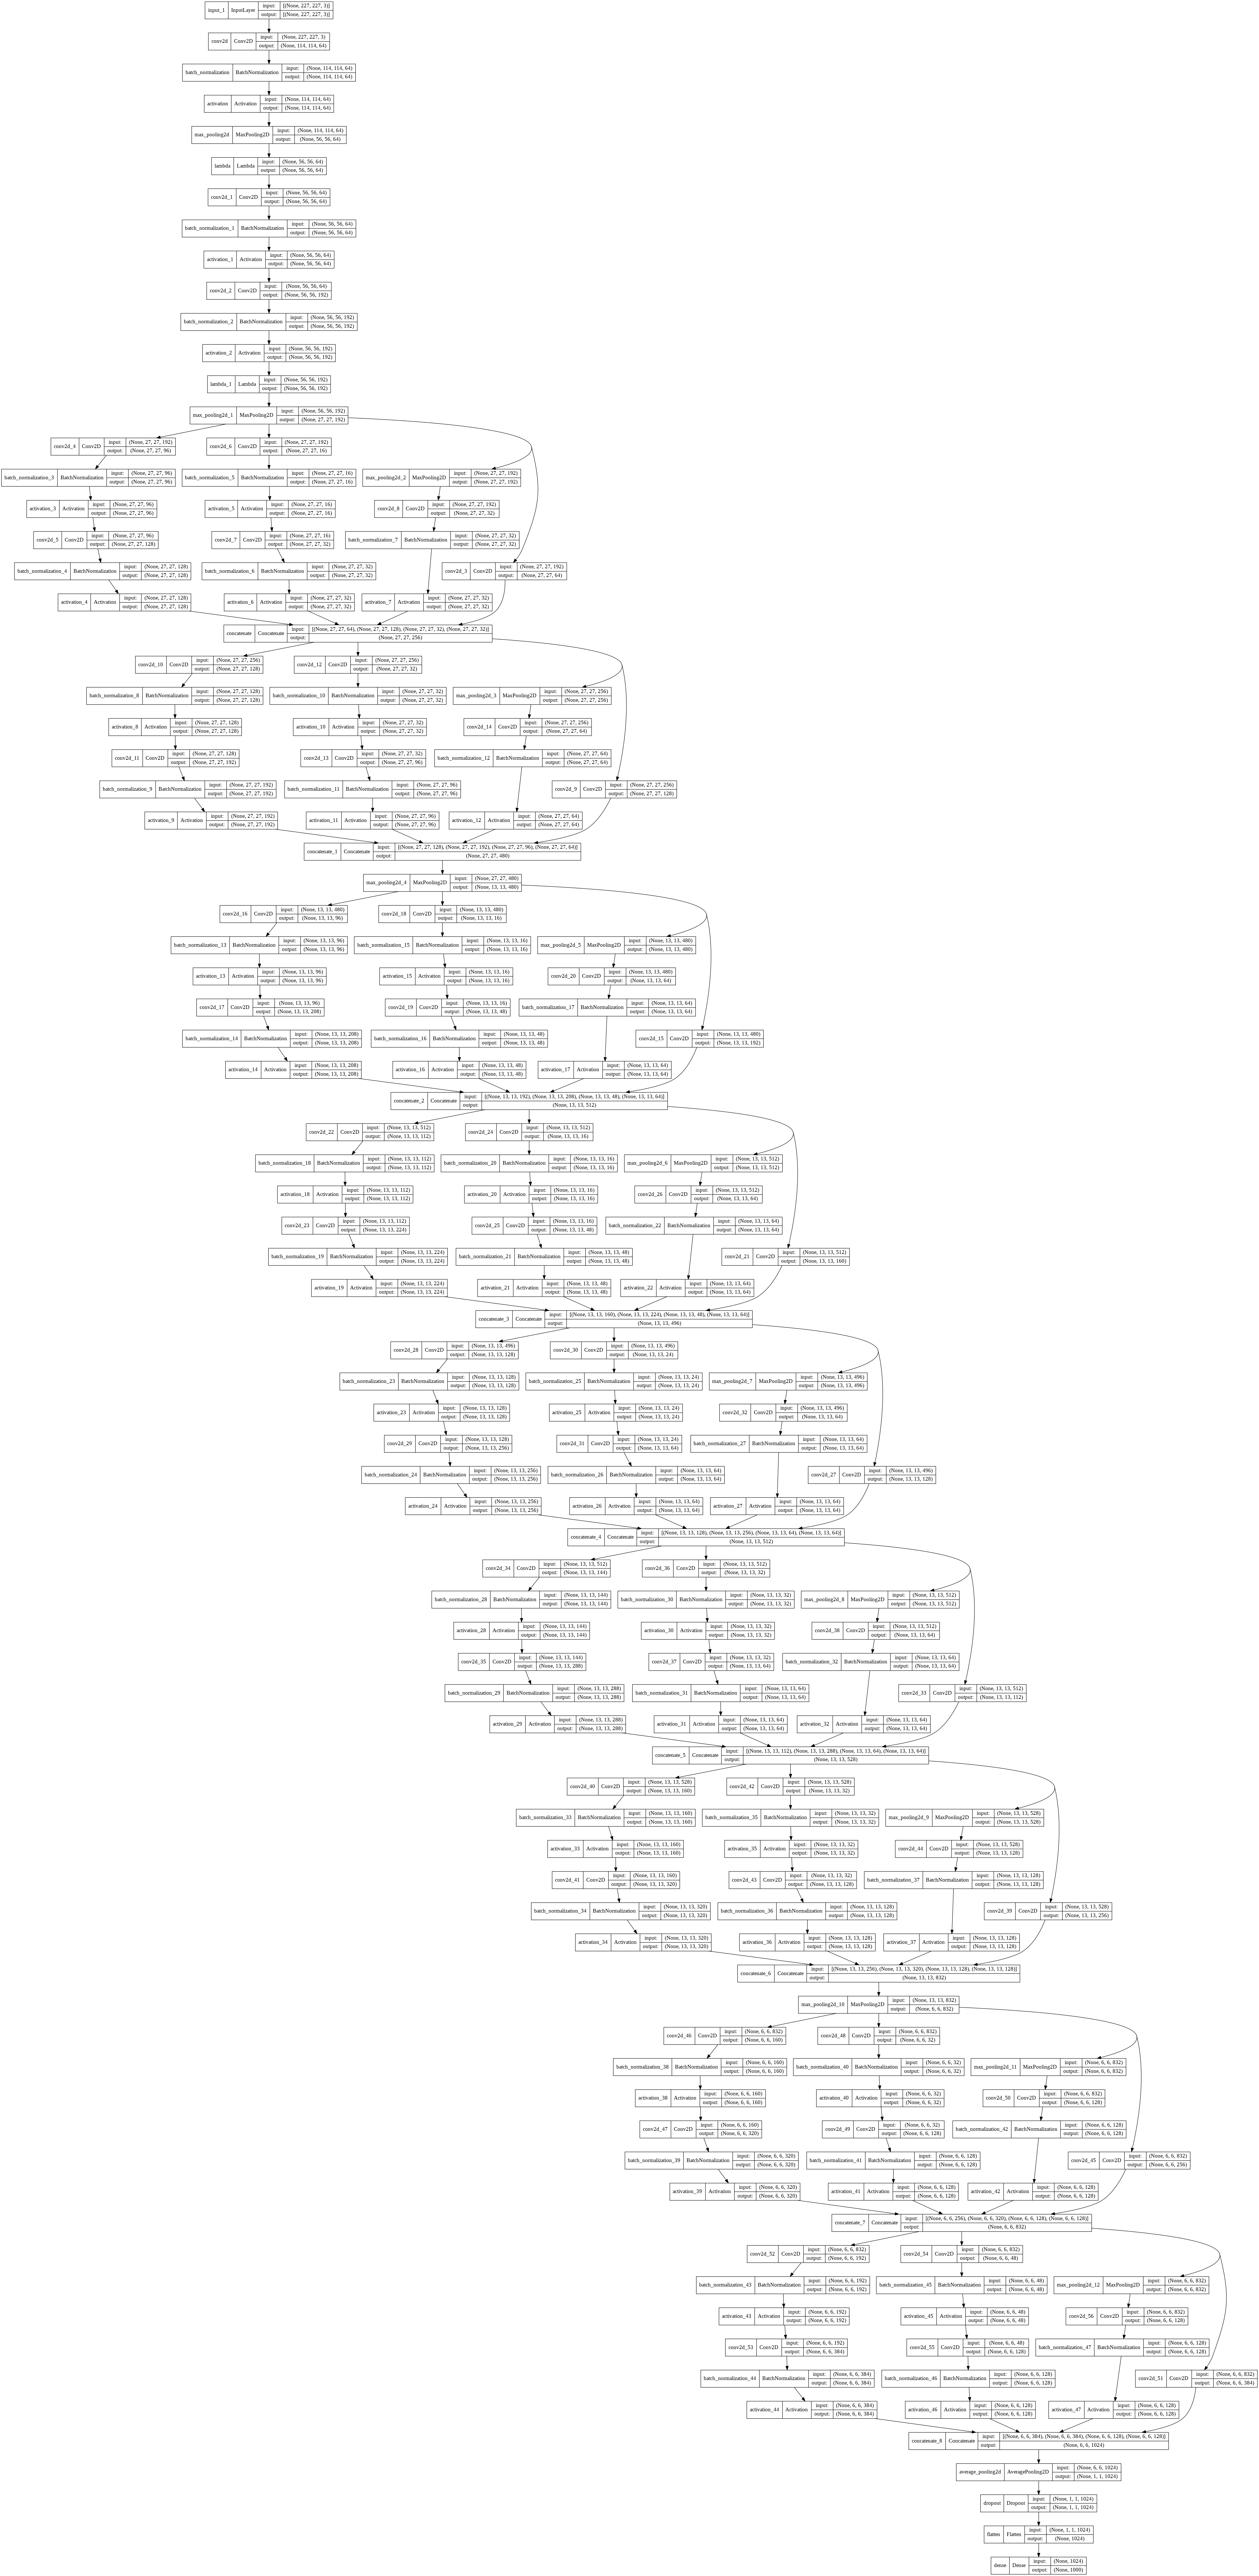

In [7]:
keras.utils.plot_model(model, "GoogLeNetWithoutAuxOutput.png", show_shapes=True)

In [8]:
keras.backend.clear_session()

In [9]:
model = GoogLeNet.build(227, 227, 3, 1000, True)

In [10]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 114, 114, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 114, 114, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

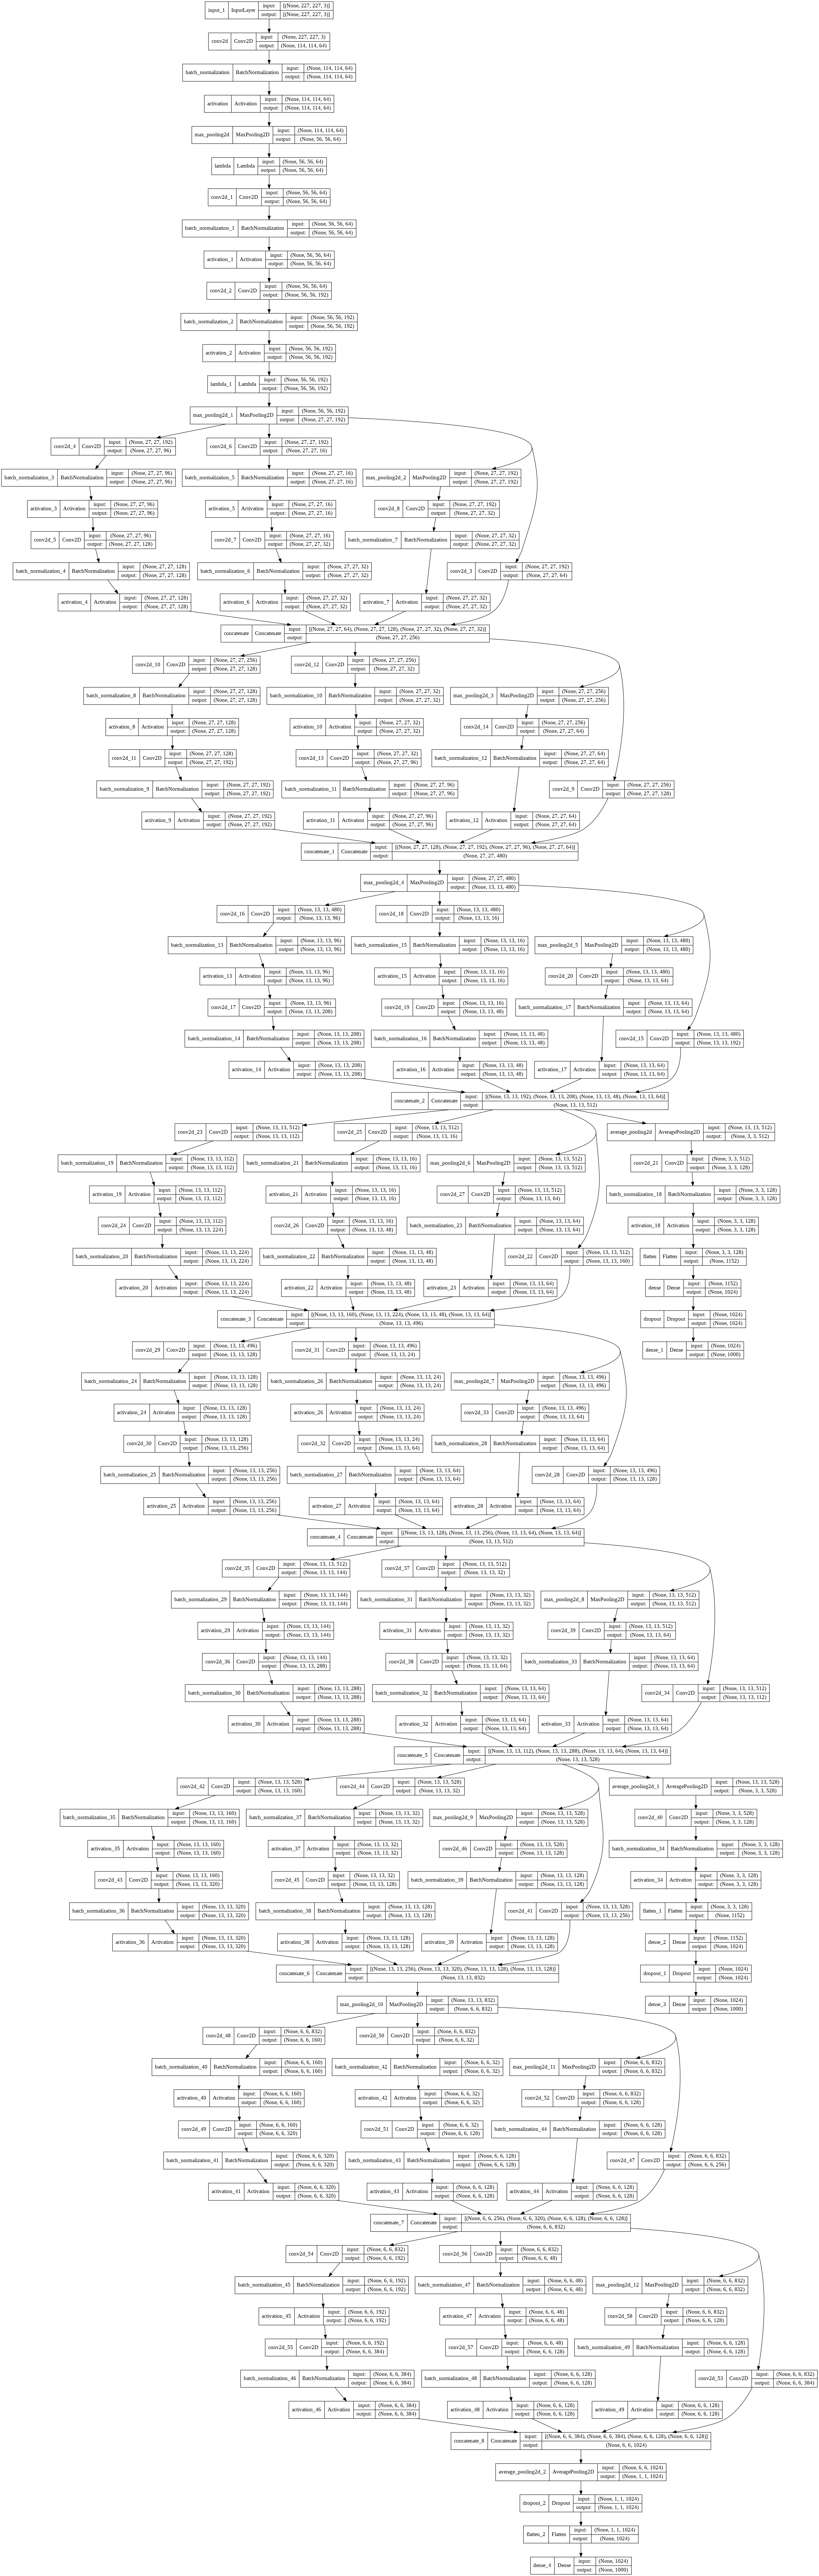

In [11]:
keras.utils.plot_model(model, "GoogLeNetWithAuxOutput.png", show_shapes=True)